In [1]:
# %matplotlib widget

import tomopy
from alignment import *
from tomo_processing import *

import numpy as np
import matplotlib.pyplot as plt

import sscCdi

In [2]:
shifts = np.load('pixel_shifts.npy')
angles = np.load('angles.npy')
donut = np.load('regular_angles_donut_shifted.npy')
donut.shape,shifts.shape,angles.shape

((361, 256, 256), (361, 2), (361, 2))

In [3]:
donut = donut/np.max(donut)

In [4]:
# sscCdi.deploy_visualizer(donut,title='Sinogram',cmap='gray')

In [5]:
aligned_data_CC = alignment_variance_field(donut, downscaling_factor=0,fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True, use_gradient = True)

Finding shift between neighboor slices...
Finding shift between slices #0/361
Finding shift between slices #50/361
Finding shift between slices #100/361
Finding shift between slices #150/361
Finding shift between slices #200/361
Finding shift between slices #250/361
Finding shift between slices #300/361
Finding shift between slices #350/361
Shifting slice #0/361
Shifting slice #50/361
Shifting slice #100/361
Shifting slice #150/361
Shifting slice #200/361
Shifting slice #250/361
Shifting slice #300/361
Shifting slice #350/361


In [6]:
# sscCdi.deploy_visualizer(aligned_data_CC,title='Sinogram',cmap='gray')

Calculating 1D mass distribution...
Finding shift between neighboor slices...
Shifting slices...
Aligning volume...
Aligning slice #0/361
Aligning slice #50/361
Aligning slice #100/361
Aligning slice #150/361
Aligning slice #200/361
Aligning slice #250/361
Aligning slice #300/361
Aligning slice #350/361


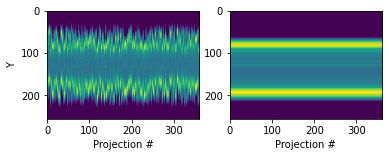

In [7]:
aligned_data_VMF, curves, total_shift = alignment_vertical_mass_fluctuation(donut, filter_sigma = 0, curve_portion = None, use_phase_gradient = False, return_common_valid_region=True, remove_null_borders = True, plot = 0) # if data is not equalized, phase gradient should be used

In [8]:
# sscCdi.deploy_visualizer(aligned_data_VMF,title='Sinogram',cmap='gray')

Calculating 1D mass distribution...
Calculating 1D mass distribution...


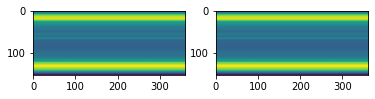

In [9]:
curves0 = get_VMF_curves(aligned_data_VMF,use_phase_gradient=False,filter_sigma=0,curve_portion=None)
curves = get_VMF_curves(aligned_data_CC,use_phase_gradient=False,filter_sigma=0,curve_portion=None)

fig, ax = plt.subplots(1,2)
ax[0].imshow(curves0.T)
ax[1].imshow(curves.T)

In [10]:
dic = {}
dic['using_wiggle'] = False
dic["project_angles_to_regular_grid"] = False

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

# dic["algorithm_dic"] = { # if FBP: filtered back-projection
#     'algorithm': "FBP",
#     'gpu': [0],
#     'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
#     'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
#     'shift center':0,
# }

dic["algorithm_dic"] = { # if eEM: emission expectation maximization
    'algorithm': "EM",
    'gpu': [0],
    'regularization': 0.1,
    'method': 'eEM', 
    'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
    'epsilon': 1e-15, #for EMTV only
    'blocksize': 20, # blocks for parallelization
}

dic["ordered_angles_filepath"] = '/ibira/lnls/labs/tepui/home/yuri.tonin/ssc-cdi/sscCdi/processing/dev/alignment/angles.npy'
recon3D_CC = tomo_recon(dic,aligned_data_CC,save=False)
recon3D_VMF = tomo_recon(dic,aligned_data_VMF,save=False)

Starting tomographic algorithm EM algorithm
	 Tomography done!
Time elapsed: Tomography: 0.5006289482116699 s
Starting tomographic algorithm EM algorithm
	 Tomography done!
Time elapsed: Tomography: 0.33465576171875 s


In [11]:
recon3D_CC[recon3D_CC>30]=0

In [12]:
sscCdi.deploy_visualizer(recon3D_CC,title='Sinogram',cmap='gray',axis=1)

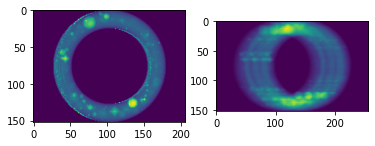

In [13]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.sum(recon3D_CC,axis=1))
ax[1].imshow(np.sum(recon3D_VMF,axis=1))

In [14]:
import numpy as np
from scipy.optimize import curve_fit

def remove_phase_gradient(img, mask, loop_count_limit=5, epsilon = 1e-3):
    """ 
    Finds a best fit plane inside a masked region of image and subtracts. 
    This process is repeated "loop_count_limit" times or until angular coefficients a,b are smaller than 1e-8

    Args:
        img (numpy.ndarray): 2D image to remove a gradient
        mask (numpy.ndarray): binary mask to indicate region of interest to extract. 
                            Points with non-zero values are considered for plane fitting.
        loop_count_limit (int, optional): Number of times to extract plane fit. Defaults to 5.
        epsilon (float, optional): Regularization parameter to stabilize matrix inversion.
                                  Set to zero for no regularization. Default is 1e-3.

    Returns:
        img (numpy.ndarray): image with subtracted phase gradient
    """

    row   = img.shape[0]
    col   = img.shape[1]
    XX,YY = np.meshgrid(np.arange(col),np.arange(row))

    a = b = c = 1e9
    counter = 0
    while np.abs(a) > 1e-8 or np.abs(b) > 1e-8 or counter < loop_count_limit:
        a,b,c = plane_fit_inside_mask( img, mask, epsilon )
        img = img - ( a*XX + b*YY + c ) # subtract plane from whole image
        counter += 1
    
    return img

# Define your 2D model function
def exp1j_plane(xy, a, b, c):
    x,y = xy
    f = np.exp(1j*(a*x + b*y + c))
    return np.angle(f.ravel())

def separate_real_and_imag_parts(xy, a, b, c):
    x,y = xy
    N = len(x)
    x_real = x[:N//2]
    x_imag = x[N//2:]
    
    N = len(y)
    y_real = y[:N//2]
    y_imag = y[N//2:]
    
    z_real = np.real(exp1j_plane((x_real,y_real), a, b, c))
    z_imag = np.imag(exp1j_plane((x_imag,y_imag), a, b, c))
    return np.hstack([z_real, z_imag])


frame = donut[0]*10
print(frame.shape)
size_y, size_x = frame.shape
x = np.linspace(0,size_x-1,size_x)
x = x/np.max(x)
y = np.linspace(0,size_y-1,size_y)
y = y/np.max(y)
Xmesh0, Ymesh0 = np.meshgrid(x,y)

def plane(x,y,a,b,c):
    return a*x+b*y+c

frame2 = 1*np.exp(1j*plane(Xmesh0,Ymesh0, 10, 4, 30))

(256, 256)


(256, 256)
True
3.124063303598947 1.2222746152835366e-05 -3.124038858106642
[ 1.04826701  4.00002169 -0.08167576]


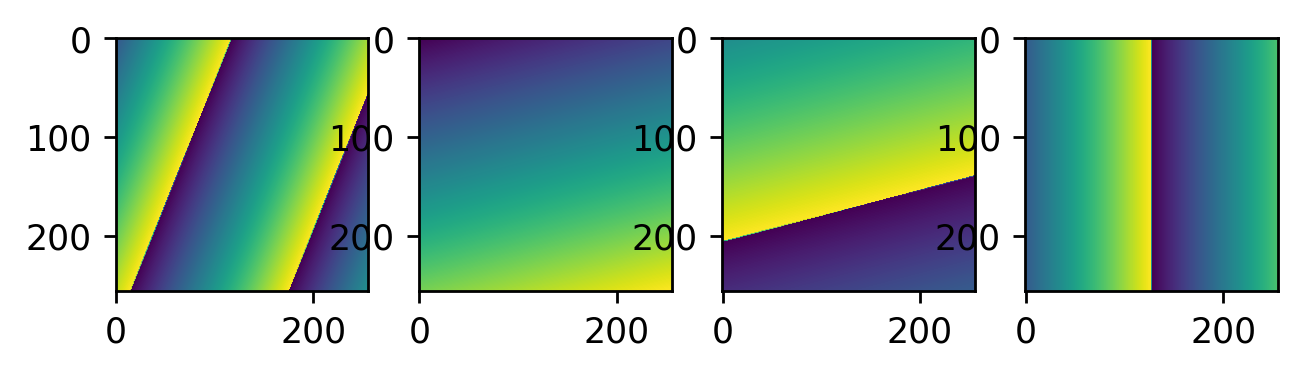

In [15]:
data = frame2
mask = np.zeros_like(data,dtype=int)
mask[0:30,0:256] = 1
mask[0:256,0:30] = 1
mask[:,:] = 1
print(data.shape)




from scipy.optimize import minimize

def remove_complex_gradient_CSAXS(data,mask,a,b,c):

    def minimization_function(data,mask,Ymesh,Xmesh,a,b,c):
        f = mask*np.abs(1 - np.exp(1j*np.angle(data))*np.exp(-1j*(a*Xmesh+b*Ymesh+c)))**2
        return np.sum(f)/np.sum(mask)

    size_y, size_x = data.shape
    x = np.linspace(0,size_x-1,size_x)
    x = x/np.max(x)
    y = np.linspace(0,size_y-1,size_y)
    y = y/np.max(y)
    Xmesh, Ymesh = np.meshgrid(x,y)
    
    # Initial guess for parameters a, b, and c
    initial_guess = [a,b,c]

    # Define the objective function for optimization
    objective_function = lambda params: minimization_function(data, mask, Ymesh, Xmesh, *params)

    # Minimize the objective function
    result = minimize(objective_function, initial_guess)
    
    return result.x, result.success

params, good = remove_complex_gradient(data,mask,1,1,1)
a_optimized, b_optimized, c_optimized = params
print(good)

fig, ax = plt.subplots(1,4,dpi=250)
ax[0].imshow(np.angle(frame2))
ax[1].imshow(plane(Xmesh0,Ymesh0,a_optimized,b_optimized,c_optimized))
ax[2].imshow(np.angle(np.exp(1j*plane(Xmesh0,Ymesh0,a_optimized,b_optimized,c_optimized))))
diff = np.angle(frame2/np.exp(1j*plane(Xmesh0,Ymesh0,a_optimized,b_optimized,c_optimized)))
ax[3].imshow(diff)
print(np.max(diff),np.mean(diff),np.min(diff))


print(params)

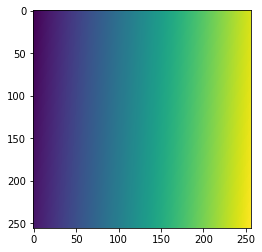

In [16]:
def remove_complex_gradient_PTYPY(a, weight=None, return_phaseramp=False):

    """
    CREDITS:
    ----
    Function adapted from Ptypy.plot_utils (https://github.com/ptycho/ptypy)

    """
    useweight = True
    if weight is None:
        useweight = False
    elif weight == "abs":
        weight = np.abs(a)

    ph = np.exp(1j * np.angle(a))
    [gx, gy] = np.gradient(ph)
    gx = -np.real(1j * gx / ph)
    gy = -np.real(1j * gy / ph)

    if useweight:
        nrm = weight.sum()
        agx = (gx * weight).sum() / nrm
        agy = (gy * weight).sum() / nrm
    else:
        agx = gx.mean()
        agy = gy.mean()

    (xx, yy) = np.indices(a.shape)
    p = np.exp(-1j * (agx * xx + agy * yy))

    if return_phaseramp:
        return a * p, p
    else:
        return a * p
    
    
a, p = remove_complex_gradient_PTYPY(data,return_phaseramp=True)

fig, ax = plt.subplots()
ax.imshow(np.angle(a))
# ax.imshow(np.angle(p))

## PMA

In [17]:
# recon3D_CC, angles

reprojection = sscRadon.radon_gpu(recon3D_CC,angles.shape[0],0)

In [20]:
reprojection.shape, recon3D_CC.shape

((152, 361, 207), (152, 207, 207))

In [24]:
import skimage

skimage.transform.radon(recon3D_CC,angles)

ValueError: The input image must be 2-D